# Prepare Dataset from the LLM Project
- The concept of converting data into a vector format is often referred to as embedding. Using a specific neural network layer or another pretrained neural network model, we can embed different data types—for example, video, audio, and text, as illustrated in figure 2.2. However, it’s important to note that different data formats require distinct embedding models. For example, an embedding model designed for text would not be suitable for embedding audio or video data.
- At its core, an embedding is a mapping from discrete objects, such as words, images, or even entire documents, to points in a continuous vector space—the primary purpose of embeddings is to convert nonnumeric data into a format that neural networks can process.
- While word embeddings are the most common form of text embedding, there are also embeddings for sentences, paragraphs, or whole documents. Sentence or paragraph embeddings are popular choices for retrieval-augmented generation. Retrievalaugmented generation combines generation (like producing text) with retrieval (like searching an external knowledge base) to pull relevant information when generating text, which is a technique that is beyond the scope of this book. Since our goal is to train GPT-like LLMs, which learn to generate text one word at a time, we will focus on word embeddings.
- Several algorithms and frameworks have been developed to generate word embeddings. One of the earlier and most popular examples is the Word2Vec approach. Word2Vec trained neural network architecture to generate word embeddings by predicting the context of a word given the target word or vice versa. The main idea behind Word2Vec is that words that appear in similar contexts tend to have similar  meanings. Consequently, when projected into two-dimensional word embeddings for visualization purposes, similar terms are clustered together.
- Word embeddings can have varying dimensions, from one to thousands. A higher dimensionality might capture more nuanced relationships but at the cost of computational efficiency.
- While we can use pretrained models such as Word2Vec to generate embeddings for machine learning models, LLMs commonly produce their own embeddings that are part of the input layer and are updated during training. The advantage of optimizing the embeddings as part of the LLM training instead of using Word2Vec is that the embeddings are optimized to the specific task and data at hand. (LLMs can also create contextualized output embeddings.)
 


## 2.2 Tokenizing Text
- Let’s discuss how we split input text into individual tokens, a required preprocessing step for creating embeddings for an LLM. These tokens are either individual words or special characters, including punctuation characters.

In [1]:
import os
import urllib.request

# efine the file_path
file_path = "../Data/verdict.txt"

# get data from a URL
if not os.path.exists("../Data/verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    urllib.request.urlretrieve(url, file_path)
    print("Data downloaded and saved to:", file_path)
else:
    print(f"File already exists: {file_path}. Skipping download.")

File already exists: ../Data/verdict.txt. Skipping download.


In [2]:
# read the content of the file (Reading in a short story as text sample into Python)
with open(file_path, 'r', encoding='utf-8') as file:
    raw_text = file.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


Our goal is to tokenize this 20,479-character short story into individual words and special characters that we can then turn into embeddings for LLM training.

**NOTE** It’s common to process millions of articles and hundreds of thousands of books—many gigabytes of text—when working with LLMs. However, for educational purposes, it’s sufficient to work with smaller text samples like a single book to illustrate the main ideas behind the text processing steps and to make it possible to run it in a reasonable time on consumer hardware.

Using some simple example text, we can use the re.split command with the following syntax to split a text on whitespace characters:

In [3]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


The result is a list of individual words, whitespaces, and punctuation characters:

This simple tokenization scheme mostly works for separating the example text into individual words; however, some words are still connected to punctuation characters that we want to have as separate list entries. We also refrain from making all text lowercase because capitalization helps LLMs distinguish between proper nouns and common nouns, understand sentence structure, and learn to generate text with proper
capitalization.

Let’s modify the regular expression splits on whitespaces (\s), commas, and periods ([,.]):

In [4]:
result = re.split(r'([,.!]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


We can see that the words and punctuation characters are now separate list entries just as we wanted:
A small remaining problem is that the list still includes whitespace characters. Optionally, we can remove these redundant characters safely as follows:

In [5]:
# strip white space
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


**NOTE** When developing a simple tokenizer, whether we should encode whitespaces as separate characters or just remove them depends on our application and its requirements. Removing whitespaces reduces the memory and computing requirements. However, keeping whitespaces can be useful if we train models that are sensitive to the exact structure of the text (for example, Python code, which is sensitive to indentation and spacing). Here, we remove whitespaces for simplicity and brevity of the tokenized outputs. Later, we will switch to a tokenization scheme that includes whitespaces.

The tokenization scheme we devised here works well on the simple sample text. Let’s modify it a bit further so that it can also handle other types of punctuation, such as question marks, quotation marks, and the double-dashes we have seen earlier in the first 100 characters of Edith Wharton’s short story, along with additional special characters:

In [6]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\'\s]|--)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


## Break Down Text into Tokens

In [7]:
result = re.split(r'([,.:;?_!"()\'\s]|--)', raw_text)
result = [item for item in result if item.strip()]
preprocessed = result
print(len(preprocessed))
print(preprocessed[:30])

4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## 2.3 Converting tokens into tokin IDs
- Next, let’s convert these tokens from a Python string to an integer representation to produce the token IDs. This conversion is an intermediate step before converting the token IDs into embedding vectors. To map the previously generated tokens into token IDs, we have to build a vocabulary first. This vocabulary defines how we map each unique word and special character to a unique integer.

We build a vocabulary by tokenizing the entire text in a training dataset into individual tokens. These individual tokens are then sorted alphabetically, and duplicate tokens are removed. The unique tokens are then aggregated into a vocabulary that defines a mapping from each unique token to a unique integer value.

In [8]:
all_words = sorted(set(preprocessed))
vocabulary_size = len(all_words)
print("Vocabulary size:", len(all_words))

Vocabulary size: 1130


In [9]:
# Create a mapping from tokens to unique integer IDs (Creating a vocabulary)
# This is a simple vocabulary mapping where each unique token is assigned a unique integer ID.
# In practice, this mapping is often more complex and may include special tokens for padding, unknown words, etc.
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 20:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)


When we want to convert the outputs of an LLM from numbers back into text, we need a way to turn token IDs into text. For this, we can create an inverse version of the vocabulary that maps token IDs back to the corresponding text tokens.

Let’s implement a complete tokenizer class in Python with an encode method that splits text into tokens and carries out the string-to-integer mapping to produce token IDs via the vocabulary. In addition, we’ll implement a decode method that carries out the reverse integer-to-string mapping to convert the token IDs back into text. The following listing shows the code for this tokenizer implementation.

In [10]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {idx: word for word, idx in vocab.items()}

    def encode(self, text):
        # Split the text into tokens based on punctuation and whitespace
        preprocessed = re.split(r'([,.:;?_!"()\'\s]|--)', text)
        # Remove empty strings and strip whitespace
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        # Convert tokens to their corresponding integer IDs using the vocabulary
        ids = [self.str_to_int[s] for s in preprocessed]
        
        return ids
    
    def decode(self, idx):
        # Convert integer IDs back to tokens using the inverse vocabulary
        text = " ".join([self.int_to_str[i] for i in idx])
        # replace spaces before the specific punctuation
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)


        return text


In [11]:
# Instantiate a new tokenizer object from the SimpleTokenizerV1 class
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
            Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

decoded = tokenizer.decode(ids)
print(decoded)  

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]
" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


Tokenizer implementations share two common methods: an encode method and a decode method. The encode method takes in the sample text, splits it into individual tokens, and converts the tokens into token IDs via the vocabulary. The decode method takes in token IDs, converts them back into text tokens, and concatenates the text tokens into natural text.

## 2.4 Adding special context tokens
- We need to modify the tokenizer to handle unknown words. We also need to address the usage and addition of special context tokens that can enhance a model’s understanding of context or other relevant information in the text. These special tokens can include markers for unknown words and document boundaries, for example. In particular, we will modify the vocabulary and tokenizer, SimpleTokenizerV2, to support two new tokens, <|unk|> and <|endoftext|>.

In [12]:
text = "Hello, do you like tea?"
print(tokenizer.encode(text))

KeyError: 'Hello'

Next, we will test the tokenizer further on text that contains unknown words and discuss additional special tokens that can be used to provide further context for an LLM during training.

In [13]:
# add end of text and unknown tokens
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(['<|endoftext|>','<|unk|>']) # place holder tokens

vocab = {token: integer for integer, token in enumerate(all_tokens)}
print("Vocabulary size:", len(vocab))

Vocabulary size: 1132


In [14]:
for i, item in enumerate(list(vocab.items())[:5]):
    print(item)

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)


In [15]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [16]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {idx: word for word, idx in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\'\s]|--)', text)
        # strip white space
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        # replace unknown tokens with <|unk|>
        preprocessed = [item if item in self.str_to_int 
                        else "<|unk|>" for item in preprocessed]
        # convert to indices
        ids = [self.str_to_int[s] for s in preprocessed]
        
        return ids
    
    def decode(self, idx):
        text = " ".join([self.int_to_str[i] for i in idx])
        # replace spaces before the specific punctuation
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [17]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [18]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [19]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

Depending on the LLM, some researchers also consider additional special tokens such as the following:
- [BOS] (beginning of sequence)—This token marks the start of a text. It signifies to the LLM where a piece of content begins.
- [EOS] (end of sequence)—This token is positioned at the end of a text and is especially useful when concatenating multiple unrelated texts, similar to <|endoftext|>. For instance, when combining two different Wikipedia articles or books, the [EOS] token indicates where one ends and the next begins.
- [PAD] (padding)—When training LLMs with batch sizes larger than one, the batch might contain texts of varying lengths. To ensure all texts have the same length, the shorter texts are extended or "padded" using the [PAD] token, up to the length of the longest text in the batch.
- The tokenizer used for GPT models does not need any of these tokens; it only uses an <|endoftext|> token for simplicity. <|endoftext|> is analogous to the [EOS] token. <|endoftext|> is also used for padding. However, as we’ll explore in subsequent chapters, when training on batched inputs, we typically use a mask, meaning we don’t attend to padded tokens. Thus, the specific token chosen for padding becomes inconsequential. Moreover, the tokenizer used for GPT models also doesn’t use an <|unk|> token for out-of-vocabulary words. Instead, GPT models use a byte pair encoding tokenizer, which breaks words down into subword units.

## 2.5 Byte pair encoding (BPE)
- Let’s look at a more sophisticated tokenization scheme based on a concept called byte pair encoding (BPE). The BPE tokenizer was used to train LLMs such as GPT-2, GPT-3, and the original model used in ChatGPT. Since implementing BPE can be relatively complicated, we will use an existing Python open source library called *tiktoken* (https://github.com/openai/tiktoken), which implements the BPE algorithm very efficiently based on source code in Rust.
- Byte Pair Encoding (BPE) is a data compression and tokenization algorithm originally developed for text compression but now widely used in natural language processing (NLP) for subword tokenization. The main idea behind BPE is to iteratively merge the most frequent pairs of consecutive bytes (characters or subwords) in a corpus to form new tokens until a desired vocabulary size is reached.
    - Here’s how BPE works in NLP, step-by-step:
        - Start with a Character Vocabulary: Initialize the vocabulary with all unique characters in the text.
        - Find the Most Frequent Pair: Scan the entire corpus and identify the most frequent pair of adjacent characters or tokens.
        - Merge the Pair: Replace every occurrence of the most frequent pair with a new combined token (subword), effectively reducing the total number of tokens.
        - Repeat: Continue this process of finding and merging the most frequent pairs until the vocabulary reaches a predefined size or no more pairs meet the frequency threshold.
        - This process turns characters into subwords and eventually into word-level tokens, allowing the model to represent rare or unseen words as combinations of known subwords.
    - Advantages of BPE include:
        - Handling Out-of-Vocabulary (OOV) Words: New or rare words can be decomposed into familiar subwords, avoiding the problem of unknown tokens.
        - Effective for Morphologically Rich Languages: BPE captures common prefixes, suffixes, and roots, helping in languages with complex word formation.
        - Balancing Vocabulary Size: BPE strikes a balance between large word-level vocabulary (which can be huge) and small character-level vocabulary (which can be inefficient).
- For example, if the word "tokenizer" is not in the vocabulary, it might be split into "token" + "izer," both known subwords, allowing the model to understand and process it effectively.
- In summary, BPE iteratively merges frequent pairs to build a flexible vocabulary of subwords that models can use efficiently, enabling them to handle diverse and complex linguistic phenomena while controlling vocabulary size and computational cost.

In [20]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.9.0


In [21]:
# instantiate the BPE tokenizer (gpt2)
# This tokenizer is based on Byte Pair Encoding (BPE) and is commonly used in GPT models.   
tokenizer = tiktoken.get_encoding("gpt2")

In [22]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)
# Use allowed_special to include <|endoftext|> token
tokenizer.encode(text, allowed_special={"<|endoftext|>"})

[15496,
 11,
 466,
 345,
 588,
 8887,
 30,
 220,
 50256,
 554,
 262,
 4252,
 18250,
 8812,
 2114,
 1659,
 617,
 34680,
 27271,
 13]

In [23]:
tokenizer.decode(tokenizer.encode(text, allowed_special={"<|endoftext|>"}))

'Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.'

We can make two noteworthy observations based on the token IDs and decoded text. First, the <|endoftext|> token is assigned a relatively large token ID, namely, 50,256. In fact, the BPE tokenizer, which was used to train models such as GPT-2, GPT-3, and the original model used in ChatGPT, has a total vocabulary size of 50,257, with <|endoftext|> being assigned the largest token ID. Second, the BPE tokenizer encodes and decodes unknown words, such as someunknownPlace, correctly. The BPE tokenizer can handle any unknown word. How does it achieve this without using <|unk|> tokens? The algorithm underlying BPE breaks down words that aren’t in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words. So, thanks to the BPE algorithm, if the tokenizer encounters an unfamiliar word during tokenization, it can represent it as a sequence of subword tokens or characters.

## 2.6 Data sampling with a sliding window
- Given a text sample, extract input blocks as subsamples that serve as input to the LLM, and the LLM’s prediction task during training is to predict the next word that follows the input block. During training, we mask out all words that are past the target. Note that the text shown in this figure must undergo tokenization before the LLM can process it.

In [24]:
# Read the raw text from the vocabulary file
with open("../Data/verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))  

5145


In [25]:
# first 50 tokens as a sample (remove the first 50 tokens from the dataset for demonstration purposes)
enc_sample = enc_text[50:]

One of the easiest and most intuitive ways to create the input–target pairs for the nextword prediction task is to create two variables, x and y, where x contains the input tokens and y contains the targets, which are the inputs shifted by 1.

In [26]:
# The context size determines how many tokens are included in the input. (chunk)
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [27]:
# By processing the inputs along with the targets, which are the inputs shifted by one 
# position, we can create the next-word prediction tasks
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [28]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


There’s only one more task before we can turn the tokens into embeddings: implementing an efficient data loader that iterates over the input dataset and returns the inputs and targets as PyTorch tensors, which can be thought of as multidimensional arrays. In particular, we are interested in returning two tensors: an input tensor containing the text that the LLM sees and a target tensor that includes the targets for the LLM to predict.

In [29]:
# use PyTorch’sbuilt-in Dataset and DataLoader classes
from importlib.metadata import version
import torch
import tiktoken

print("PyTorch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

PyTorch version: 2.7.1
tiktoken version: 0.9.0


In [30]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
                
        # Check for MPS (Mac)
        if torch.backends.mps.is_available():
            self.device = torch.device("mps")
            print("Using MPS device")
        else:
            self.device = torch.device("cpu")
            print("MPS device not found. Using CPU.")

        # Tonkenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={'<|endoftext|>'})

        # Use sliding windowto chunk the text into overlapping sequences
        for i in range(0, len(token_ids) - max_length, stride):
            # Input chunk always has max_length tokens
            input_chunk = token_ids[i: i + max_length]
            # Target chunk is shifted by one token
            target_chunk = token_ids[i + 1: i + max_length + 1]

            # Ensure the chunks are of the same length
            self.input_ids.append(torch.tensor(input_chunk, device=self.device))
            self.target_ids.append(torch.tensor(target_chunk, device=self.device)) 
            
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [31]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True, 
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create Dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    
    return dataloader

#### Read Text

In [32]:
with open("../Data/verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [33]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=4, shuffle=False
    )

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

Using MPS device
[tensor([[  40,  367, 2885, 1464]], device='mps:0'), tensor([[ 367, 2885, 1464, 1807]], device='mps:0')]


In [34]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[1807, 3619,  402,  271]], device='mps:0'), tensor([[ 3619,   402,   271, 10899]], device='mps:0')]


Deep learning, you may know that small batch sizes require less memory during training but lead to more noisy model updates. Just like in regular deep learning, the batch size is a tradeoff and a hyperparameter to experiment with when training LLMs.

When creating multiple batches from the input dataset, we slide an input window across the text. If the stride is set to 1, we shift the input window by one position when creating the next batch. If we set the stride equal to the input window size, we can prevent overlaps between the batches.

In [35]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4,
    shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Using MPS device
Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]], device='mps:0')

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]], device='mps:0')


Note that we increase the stride to 4 to utilize the data set fully (we don’t skip a single word). This avoids any overlap between the batches since more overlap could lead to increased overfitting.

## 2.7 Creating token embeddings
- Preparation involves tokenizing text, converting text tokens to token IDs, and converting token IDs into embedding vectors.
- The last step in preparing the input text for LLM training is to convert the token IDs into embedding vectors, these embedding weights with random values. This initialization serves as the starting point for the LLM’s learning process.

In [36]:
tokenizer = tiktoken.get_encoding("gpt2")

In [37]:
print(dir(tokenizer))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_core_bpe', '_encode_bytes', '_encode_only_native_bpe', '_encode_single_piece', '_mergeable_ranks', '_pat_str', '_special_tokens', 'decode', 'decode_batch', 'decode_bytes', 'decode_bytes_batch', 'decode_single_token_bytes', 'decode_tokens_bytes', 'decode_with_offsets', 'encode', 'encode_batch', 'encode_ordinary', 'encode_ordinary_batch', 'encode_single_token', 'encode_to_numpy', 'encode_with_unstable', 'eot_token', 'is_special_token', 'max_token_value', 'n_vocab', 'name', 'special_tokens_set', 'token_byte_values']


In [38]:
tokenizer.n_vocab

50257

In [39]:
# samll example
input_idx = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3

# Create token embeddings
# The last step in preparing the input text for LLM training is to convert the token IDs
# into embedding vectors, which are trainable parameters in the model.
# This is typically done using an embedding layer in PyTorch.
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [40]:
# will be adjusted during training
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [41]:
embedding_layer(torch.tensor([3]))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)

In [42]:
embedding_layer(torch.tensor([2]))

tensor([[ 1.2753, -0.2010, -0.1606]], grad_fn=<EmbeddingBackward0>)

In [43]:
input_idx

tensor([2, 3, 5, 1])

In [44]:
embedding_layer(input_idx)

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)

In [45]:
embedding_layer(input_idx.detach().clone())

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)

In [46]:
embedding_layer = torch.nn.Embedding(tokenizer.n_vocab, output_dim)
print(embedding_layer)
print(embedding_layer.weight)

Embedding(50257, 3)
Parameter containing:
tensor([[-2.1338,  1.0524, -0.3885],
        [-0.9343, -0.4991, -1.0867],
        [ 0.9624,  0.2492,  0.6266],
        ...,
        [ 0.9609, -1.3697,  0.1381],
        [-1.2365,  1.9319,  0.4730],
        [ 0.7365,  0.1316,  0.2379]], requires_grad=True)


## 2.8 Encoding word positions
- In principle, token embeddings are a suitable input for an LLM. However, a minor shortcoming of LLMs is that their self-attention mechanism doesn’t have a notion of position or order for the tokens within a sequence. The way the previously introduced embedding layer works is that the same token ID always gets mapped to the same vector representation, regardless of where the token ID is positioned in the input sequence.

In [47]:
print(tokenizer.n_vocab)
vocab_size = tokenizer.n_vocab
output_dim = 256 # gpt2 output size approx 1024

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

50257


In [48]:
max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, 
                                  max_length=max_length, stride=max_length, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Using MPS device
Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]], device='mps:0')

Inputs shape:
 torch.Size([8, 4])


In [49]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Move the token embedding layer to the same device as the inputs
token_embedding_layer = token_embedding_layer.to(device)
# 
token_embeddings = token_embedding_layer(inputs)

print("\nToken embeddings shape:\n", token_embeddings.shape)


Token embeddings shape:
 torch.Size([8, 4, 256])


The 8 × 4 × 256–dimensional tensor output shows that each token ID is now embedded
as a 256-dimensional vector.

For a GPT model’s absolute embedding approach, we just need to create another
embedding layer that has the same embedding dimension as the token_embedding_
layer:

Instead of focusing on the absolute position of a token, the emphasis of relative positional embeddings is on the relative position or distance between tokens. This means the model learns the relationships in terms of "how far apart" rather than "at which exact position." The advantage here is that the model can generalize better to sequences of varying lengths, even if it hasn’t seen such lengths during training. Both types of positional embeddings aim to augment the capacity of LLMs to understand the order and relationships between tokens, ensuring more accurate and context-aware predictions. The choice between them often depends on the specific application and the nature of the data being processed. OpenAI’s GPT models use absolute positional embeddings that are optimized during the training process rather than being fixed or predefined like the positional encodings in the original transformer model. This optimization process is part of the model training itself. For now, let’s create the initial positional embeddings to create the LLM inputs.

In [50]:
context_length = max_length

# Initialize the embedding layer and move it to the device
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim).to(device)

# Create the input tensor on the specified device
pos_embeddings = pos_embedding_layer(torch.arange(context_length, device=device))

print(pos_embeddings.shape)

torch.Size([4, 256])


As we can see, the positional embedding tensor consists of four 256-dimensional vectors.
We can now add these directly to the token embeddings, where PyTorch will add
the 4 × 256–dimensional pos_embeddings tensor to each 4 × 256–dimensional token
embedding tensor in each of the eight batches:

In [51]:
pos_embedding_layer.weight

Parameter containing:
tensor([[-0.7851,  1.5557,  1.1355,  ...,  0.5553, -0.6299,  0.2980],
        [ 0.8141,  0.9801, -0.9307,  ...,  2.2669, -1.0472, -0.0354],
        [-1.4536, -1.0188,  0.4802,  ...,  1.3324,  1.0717, -0.1117],
        [-0.4525,  0.1157,  1.9147,  ..., -0.4439, -0.8569, -0.6267]],
       device='mps:0', requires_grad=True)

In [52]:
pos_embedding_layer(torch.arange(context_length).to(device))

tensor([[-0.7851,  1.5557,  1.1355,  ...,  0.5553, -0.6299,  0.2980],
        [ 0.8141,  0.9801, -0.9307,  ...,  2.2669, -1.0472, -0.0354],
        [-1.4536, -1.0188,  0.4802,  ...,  1.3324,  1.0717, -0.1117],
        [-0.4525,  0.1157,  1.9147,  ..., -0.4439, -0.8569, -0.6267]],
       device='mps:0', grad_fn=<EmbeddingBackward0>)

In [53]:
# Combine token embeddings and positional embeddings
# The final input to the LLM is the sum of the token embeddings and the positional embeddings.
# This way, the model can learn to associate each token with its position in the sequence.
input_embeddings = token_embeddings + pos_embeddings
print("\nInput embeddings shape:\n", input_embeddings.shape)


Input embeddings shape:
 torch.Size([8, 4, 256])


LLMs require textual data to be converted into numerical vectors, known as embeddings, since they can’t process raw text. Embeddings transform discrete data (like words or images) into continuous vector spaces, making them compatible with neural network operations.
- As the first step, raw text is broken into tokens, which can be words or characters. Then, the tokens are converted into integer representations, termed token IDs.
- Special tokens, such as <|unk|> and <|endoftext|>, can be added to enhance the model’s understanding and handle various contexts, such as unknown words or marking the boundary between unrelated texts.
- The byte pair encoding (BPE) tokenizer used for LLMs like GPT-2 and GPT-3 can efficiently handle unknown words by breaking them down into subword units or individual characters.
- We use a sliding window approach on tokenized data to generate input–target pairs for LLM training.
- Embedding layers in PyTorch function as a lookup operation, retrieving vectors corresponding to token IDs. The resulting embedding vectors provide continuous representations of tokens, which is crucial for training deep learning models like LLMs.
- While token embeddings provide consistent vector representations for each token, they lack a sense of the token’s position in a sequence. To rectify this, two main types of positional embeddings exist: absolute and relative. OpenAI’s GPT models utilize absolute positional embeddings, which are added to the token embedding vectors and are optimized during the model training.

## Chapter 3: Coding Attention Mechanisms
In self-attention, the "self" refers to the mechanism’s ability to compute attention weights by relating different positions within a single input sequence. It assesses and learns the relationships and dependencies between various parts of the input itself, such as words in a sentence or pixels in an image. This is in contrast to traditional attention mechanisms, where the focus is on the relationships between elements of two different sequences, such as in sequence-to sequence models where the attention might be between an input sequence and an output sequence.

Self-attention is a mechanism that allows each position in the input sequence to consider the relevancy of, or "attend to," all other positions in the same sequence when computing the representation of a sequence. Self-attention is a key component of contemporary LLMs based on the transformer architecture, such as the GPT series. Self-attention is a mechanism in transformers used to compute more efficient input representations by allowing each position in a sequence to interact with and weigh the importance of all other positions within the same sequence.

Self-attention is a mechanism in machine learning that allows a model to weigh the importance of different words in a sequence when processing a single word. In a simplified way, it's how a model reads a sentence and decides what to pay attention to in order to understand the meaning of each word.

### 3.3.1 A simple self-attention mechanism without trainable weights

The first step of implementing self-attention is to compute the intermediate values ω, referred to as attention scores

In [54]:
import torch
 # each row is embedding vector (simple attention mechanism)
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
     [0.55, 0.87, 0.66], # journey (x^2)
     [0.57, 0.85, 0.64], # starts (x^3)
     [0.22, 0.58, 0.33], # with (x^4)
     [0.77, 0.25, 0.10], # one (x^5)
     [0.05, 0.80, 0.55]] # step (x^6)
)

In [55]:
# The input query is the second item in the inputs tensor
input_query = inputs[1]
input_query

tensor([0.5500, 0.8700, 0.6600])

In [56]:
input_1 = inputs[0]
input_1

tensor([0.4300, 0.1500, 0.8900])

In [57]:
0.5500 * 0.4300 + 0.8700 * 0.1500 + 0.6600 * 0.8900

0.9544

In [58]:
torch.dot(input_1, input_query)

tensor(0.9544)

In [59]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

In [60]:
input_query

tensor([0.5500, 0.8700, 0.6600])

In [61]:
for idx, ele in enumerate(inputs[0]):
    # print(ele)
    print(inputs[0][idx] * input_query[idx])

tensor(0.2365)
tensor(0.1305)
tensor(0.5874)


illustrates how we calculate the intermediate attention scores between the query token and each input token. We determine these scores by computing the dot product of the query, x(2), with every other input token:

In [62]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


## Understanding dot products
A dot product is essentially a concise way of multiplying two vectors element-wise and
then summing the products, which can be demonstrated as follows:

In [63]:
res = 0.
for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]
print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


Beyond viewing the dot product operation as a mathematical tool that combines two vectors to yield a scalar value, the dot product is a measure of similarity because it quantifies how closely two vectors are aligned: a higher dot product indicates a greater degree of alignment or similarity between the vectors. In the context of self-attention mechanisms, the dot product determines the extent to which each element in a sequence focuses on, or “attends to,” any other element: the higher the dot product, the higher the similarity and attention score between two elements.

In [64]:
torch.empty(inputs.shape[0])

tensor([0., 0., 0., 0., 0., 0.])

In [65]:
# normalize the attention scores
attn_scores_2_temp = attn_scores_2 / attn_scores_2.sum()

attn_scores_2_temp

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])

In [66]:
attn_scores_2_temp.sum()

tensor(1.0000)

In practice, it’s more common and advisable to use the softmax function for normalization. This approach is better at managing extreme values and offers more favorable gradient properties during training. The following is a basic implementation of the softmax function for normalizing the attention scores:

In [67]:
# not stable for certain values, e.g., large values
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In addition, the softmax function ensures that the attention weights are always positive. This makes the output interpretable as probabilities or relative importance, where higher weights indicate greater importance. Note that this naive softmax implementation (softmax_naive) may encounter numerical instability problems, such as overflow and underflow, when dealing with large or small input values. Therefore, in practice, it’s advisable to use the PyTorch implementation of softmax, which has been extensively optimized for performance:

In [68]:
# better to use optimized softmax function
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [69]:
query = inputs[1] # Use the second input as the query

contex_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    contex_vec_2 += attn_weights_2[i] * x_i

print("Context vector:", contex_vec_2)

Context vector: tensor([0.4419, 0.6515, 0.5683])


### 3.3.2 Computing attention weights for all input tokens

In [70]:
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
     [0.55, 0.87, 0.66], # journey (x^2)
     [0.57, 0.85, 0.64], # starts (x^3)
     [0.22, 0.58, 0.33], # with (x^4)
     [0.77, 0.25, 0.10], # one (x^5)
     [0.05, 0.80, 0.55]] # step (x^6)
)

print(inputs)

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])


In [71]:
# create empty tensors
attn_scores = torch.empty(6, 6)
# iterate entire 6x6 matrix
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
        
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [72]:
# Using matrix multiplication to compute attention scores
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [73]:
attn_weights = torch.softmax(attn_scores, dim=1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [74]:
attn_weights
print(attn_weights.sum(dim=1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [75]:
# Using matrix multiplication to compute attention scores
attn_scores = inputs @ inputs.T
attn_weights = torch.softmax(attn_scores, dim=1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [76]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## 3.4.1 Implementing self-attention with trainable weights
Our next step will be to implement the self-attention mechanism used in the original transformer architecture, the GPT models, and most other popular LLMs. This self-attention mechanism is also called scaled dot-product attention.

In [77]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

In [78]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out))
W_key = torch.nn.Parameter(torch.rand(d_in, d_out))
W_value = torch.nn.Parameter(torch.rand(d_in, d_out))

print("W_query:", W_query)
print("W_key:", W_key)
print("W_value:", W_value)

W_query: Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]], requires_grad=True)
W_key: Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]], requires_grad=True)
W_value: Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]], requires_grad=True)


In [79]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

query_2, key_2, value_2

(tensor([0.4306, 1.4551], grad_fn=<SqueezeBackward4>),
 tensor([0.4433, 1.1419], grad_fn=<SqueezeBackward4>),
 tensor([0.3951, 1.0037], grad_fn=<SqueezeBackward4>))

The output for the query results in a two-dimensional vector since we set the number of columns of the corresponding weight matrix, via d_out, to 2:

## Weight parameters vs. attention weights
- In the weight matrices W, the term “weight” is short for “weight parameters,” the values of a neural network that are optimized during training. This is not to be confused with the attention weights. As we already saw, attention weights determine the extent to which a context vector depends on the different parts of the input (i.e., to what
extent the network focuses on different parts of the input). In summary, weight parameters are the fundamental, learned coefficients that define the network’s connections, while attention weights are dynamic, context-specific values.
- In essence, matrix multiplication encapsulates the chaining of linear geometric operations: every time you compose two or more geometric linear transformations, the matrix product gives you a single matrix representing their combined effect.

In [80]:
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [81]:
keys

tensor([[0.3669, 0.7646],
        [0.4433, 1.1419],
        [0.4361, 1.1156],
        [0.2408, 0.6706],
        [0.1827, 0.3292],
        [0.3275, 0.9642]], grad_fn=<MmBackward0>)

In [82]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524, grad_fn=<DotBackward0>)


In [83]:
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
       grad_fn=<SqueezeBackward4>)


Now, we want to go from the attention scores to the attention weights. We compute the attention weights by scaling the attention scores and using the softmax function. However, now we scale the attention scores by dividing
them by the square root of the embedding dimension of the keys (taking the square root is mathematically the same as exponentiating by 0.5):

In [84]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820],
       grad_fn=<SoftmaxBackward0>)


#### The rationale behind scaled-dot product attention:
The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. For instance, when scaling up the embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them. As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. These small gradients can drastically slow down learning or cause training to stagnate. The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.

Similar to when we computed the context vector as a weighted sum over the input vectors, we now compute the context vector as a weighted sum over the value vectors. Here, the attention weights serve as a weighting factor that weighsthe respective importance of each value vector. Also as before, we can use matrix multiplication to obtain the output in one step:

In [85]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210], grad_fn=<SqueezeBackward4>)


### Why query, key, and value?
The terms “key,” “query,” and “value” in the context of attention mechanisms are borrowed from the domain of information retrieval and databases, where similar concepts are used to store, search, and retrieve information. A query is analogous to a search query in a database. It represents the current item (e.g., a word or token in a sentence) the model focuses on or tries to understand. The query is used to probe the other parts of the input sequence to determine how much attention to pay to them. The key is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key. These keys are used to match the query. The value in this context is similar to the value in a key-value pair in a database. It represents the actual content or representation of the input items. Once the model determines which keys (and thus which parts of the input) are most relevant to the query (the current focus item), it retrieves the corresponding values.

## 3.4.2 Implementing a compact self-attention Class

In [86]:
import torch
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        # Compute queries, keys, and values vectors
        queries = x @ self.W_query
        keys = x @ self.W_key
        values = x @ self.W_value

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / d_k**0.5, dim=-1)
        context_vec = attn_weights @ values

        return context_vec
    
torch.manual_seed(123)
# Assuming you have a device variable defined, e.g.:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Ensure the input tensor 'inputs' is also on the same device
inputs = inputs.to(device)

# Instantiate Class
sa_v1 = SelfAttention_v1(d_in, d_out)
# Move the entire module and all its parameters to the MPS device
sa_v1.to(device)
sa_v1(inputs)

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], device='mps:0', grad_fn=<MmBackward0>)

In [87]:
m = torch.nn.Linear(2,3)
m.weight

Parameter containing:
tensor([[-0.1668,  0.2270],
        [ 0.5000,  0.1317],
        [ 0.1934,  0.6825]], requires_grad=True)

#### Weight parameters vs. attention weights
In the weight matrices W, the term “weight” is short for “weight parameters,” the values of a neural network that are optimized during training. This is not to be confused with the attention weights. As we already saw, attention weights determine the extent to which a context vector depends on the different parts of the input (i.e., to what extent the network focuses on different parts of the input).

In summary, weight parameters are the fundamental, learned coefficients that define
the network’s connections, while attention weights are dynamic, context-specific values.

#### The rationale behind scaled-dot product attention
The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. For instance, when scaling up the embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them. As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. These small gradients can drastically slow down learning or cause training to stagnate. The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.

In [88]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        # Compute queries, keys, and values vectors
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / d_k**0.5, dim=-1)
        context_vec = attn_weights @ values

        return context_vec
    
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
sa_v2.to(device)
sa_v2(inputs)

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], device='mps:0', grad_fn=<MmBackward0>)

#### Comparing SelfAttention_v1 and SelfAttention_v2
Note that nn.Linear in SelfAttention_v2 uses a different weight initialization scheme as nn.Parameter(torch.rand(d_in, d_out)) used in SelfAttention_v1, which causes both mechanisms to produce different results. To check that both implementations, SelfAttention_v1 and SelfAttention_v2, are otherwise similar, we can transfer the weight matrices from a SelfAttention_v2 object to a Self-Attention_v1, such that both objects then produce the same results. Your task is to correctly assign the weights from an instance of SelfAttention_v2 to an instance of SelfAttention_v1. To do this, you need to understand the relationship between the weights in both versions. (Hint: nn.Linear stores the weight matrix in a transposed form.) After the assignment, you should observe that both instances produce the same outputs.

## 3.5 Hiding future words with causal attention
- For many LLM tasks, you will want the self-attention mechanism to consider only the tokens that appear prior to the current position when predicting the next token in a sequence. Causal attention, also known as *masked attention*, is a specialized form of self-attention. It restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention scores. This is in contrast to the standard self-attention mechanism, which allows access to the entire input sequence at once.
- Now, we will modify the standard self-attention mechanism to create a causal attention mechanism, which is essential for developing an LLM in the subsequent chapters. To achieve this in GPT-like LLMs, for each token processed, we mask out the future tokens, which come after the current token in the input text. We mask out the attention weights above the diagonal, and we normalize the nonmasked attention weights such that the attention weights sum to 1 in each row. 
- In causal attention, we mask out the attention weights above the diagonal such that for a given input, the LLM can’t access future tokens when computing the context vectors using the attention weights. We only keep the attention weights for the words before and in the current position.

### 3.5.1 Apply a causal attention mask
- Our next step is to implement the causal attention mask in code. To implement the
steps to apply a causal attention mask to obtain the masked attention weights, let’s work with the attention scores and weights from the previous section to code the causal attention mechanism.
- One way to obtain the masked attention weight matrix in causal attention is to apply the softmax function to the attention scores, zeroing out the elements above the diagonal and normalizing the resulting matrix.

In [89]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)


In [90]:
# Implement the second step using PyTorch’s tril function to create a mask
# where the values above the diagonal are zero:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length).to(device))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]], device='mps:0')


#### Information leakage
When we apply a mask and then renormalize the attention weights, it might initially appear that information from future tokens (which we intend to mask) could still influence the current token because their values are part of the softmax calculation. However, the key insight is that when we renormalize the attention weights after masking, what we’re essentially doing is recalculating the softmax over a smaller subset (since masked positions don’t contribute to the softmax value). The mathematical elegance of softmax is that despite initially including all positions in the denominator, after masking and renormalizing, the effect of the masked positions is nullified—they don’t contribute to the softmax score in any meaningful way. In simpler terms, after masking and renormalization, the distribution of attention weights is as if it was calculated only among the unmasked positions to begin with. This ensures there’s no information leakage from future (or otherwise masked) tokens as we intended.

In [91]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]], device='mps:0',
       grad_fn=<MulBackward0>)


In [92]:
# renormalize
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]], device='mps:0',
       grad_fn=<DivBackward0>)


While we could wrap up our implementation of causal attention at this point, we can still improve it. Let’s take a mathematical property of the softmax function and implement the computation of the masked attention weights more efficiently in fewer steps.

The softmax function converts its inputs into a probability distribution. When negative infinity values (-∞) are present in a row, the softmax function treats them as zero probability. (Mathematically, this is because e –∞ approaches 0.)

In [93]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1).to(device)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]], device='mps:0',
       grad_fn=<MaskedFillBackward0>)


In [94]:
torch.exp(torch.tensor(-9999999999999)), torch.exp(torch.tensor(float("-inf")))

(tensor(0.), tensor(0.))

In [95]:
attn_weights = torch.softmax(masked / d_k**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)


## 3.5.2 Masking addtional attention weights with dropout
- Dropout in deep learning is a technique where randomly selected hidden layer units are ignored during training, effectively "dropping" them out. This method helps prevent overfitting by ensuring that a model does not become overly reliant on any specific set of hidden layer units. It’s important to emphasize that dropout is only used during training and is disabled afterward.
- In the transformer architecture, including models like GPT, dropout in the attention mechanism is typically applied at two specific times: after calculating the attention weights or after applying the attention weights to the value vectors. Here we will apply the dropout mask after computing the attention weights, because it’s the more common variant in practice.
- In the following code example, we use a dropout rate of 50%, which means masking out half of the attention weights. (When we train the GPT model in later chapters, we will use a lower dropout rate, such as 0.1 or 0.2.)

**NOTE:** We apply an additional dropout mask (upper right) to zero out additional attention weights to reduce overfitting during training, but the modern GPT model does not use this!

In [96]:
torch.manual_seed(123)
# dropping 50%
dropout = torch.nn.Dropout(0.5).to(device)
example = torch.ones(6, 6).to(device)
print(dropout(example)) # larger because it is rescaling the values

tensor([[0., 0., 0., 2., 2., 2.],
        [2., 2., 0., 0., 0., 2.],
        [0., 2., 2., 2., 2., 2.],
        [2., 0., 0., 0., 2., 0.],
        [2., 2., 0., 2., 0., 0.],
        [0., 0., 2., 2., 0., 2.]], device='mps:0')


In [97]:
dropout_rate = 0.5
1/ (1 - dropout_rate)

2.0

When applying dropout to an attention weight matrix with a rate of 50%, half of the elements in the matrix are randomly set to zero. To compensate for the reduction in active elements, the values of the remaining elements in the matrix are scaled up by a factor of 1/0.5 = 2. This scaling is crucial to maintain the overall balance of the attention weights, ensuring that the average influence of the attention mechanism remains consistent during both the training and inference phases.

In [98]:
attn_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)

In [99]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.1034, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3331, 0.3084, 0.0000, 0.3058]], device='mps:0',
       grad_fn=<MulBackward0>)


## 3.5.3 Implementing a compact causal self-attention class
- We will now incorporate the causal attention and dropout modifications into the SelfAttention Python class we developed in section 3.4. This class will then serve as a template for developing multi-head attention, which is the final attention class we will
implement.
- But before we begin, let’s ensure that the code can handle batches consisting of more than one input so that the CausalAttention class supports the batch outputs produced by the data loader we implemented in chapter 2.

In [100]:
inputs, inputs.shape

(tensor([[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]], device='mps:0'),
 torch.Size([6, 3]))

This results in a three-dimensional tensor consisting of two input texts with six tokens each, where each token is a three-dimensional embedding vector:

In [101]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch)
print(batch.shape)

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]], device='mps:0')
torch.Size([2, 6, 3])


The following CausalAttention class is similar to the SelfAttention class we implemented earlier, except that we added the dropout and causal mask components.

Added a self.register_buffer() call in the __init__ method. The use of register_buffer in PyTorch is not strictly necessary for all use cases but offers several advantages here. For instance, when we use the CausalAttention class in our LLM, buffers are automatically moved to the appropriate device (CPU or GPU) along with our model, which will be relevant when training our LLM. This means we don’t need to manually ensure these tensors are on the same device as your model parameters, avoiding device mismatch errors.

In [102]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout =  torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # Compute queries, keys, and values vectors
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)
        # Transpose dimensions 1 and 2, keeping the batch dimension at the first position (0).
        attn_scores = queries @ keys.transpose(1, 2)
        # In PyTorch, operations with a trailing underscore are performed in-place, 
        # avoiding unnecessary memory copies. (causal mask)
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / d_k**0.5, dim=-1)
        # dropout
        attn_weights = self.dropout(attn_weights)
        # Calc context vector
        context_vec = attn_weights @ values

        return context_vec

torch.manual_seed(789)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.5)
ca.to(device)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)
print(context_vecs)

context_vecs.shape: torch.Size([2, 6, 2])
tensor([[[-0.1744,  0.0572],
         [-0.1019,  0.0686],
         [-0.0704,  0.0474],
         [-0.1061,  0.0833],
         [-0.0305,  0.2082],
         [-0.0792,  0.0823]],

        [[ 0.0000,  0.0000],
         [-0.0962,  0.0315],
         [-0.0704,  0.0474],
         [-0.1484,  0.0821],
         [-0.0234,  0.1903],
         [-0.0997,  0.0357]]], device='mps:0', grad_fn=<UnsafeViewBackward0>)


## 3.6 Extending single-head attention to multi-head attention
- Our final step will be to extend the previously implemented causal attention class over multiple heads. This is also called multi-head attention.
- The term "multi-head" refers to dividing the attention mechanism into multiple "heads," each operating independently. In this context, a single causal attention module can be considered single-head attention, where there is only one set of attention weights processing the input sequentially.

**NOTE:** We will tackle this expansion from causal attention to multi-head attention. First, we will intuitively build a multi-head attention module by stacking multiple Causal- Attention modules. Then we will then implement the same multi-head attention module in a more complicated but more computationally efficient way.

### 3.6.1 Stacking multiple single-head attention layers
- In practical terms, implementing multi-head attention involves creating multiple instances of the self-attention mechanism, each with its own weights, and then combining their outputs. Using multiple instances of the self-attention mechanism can be computationally intensive, but it’s crucial for the kind of complex pattern recognition that models like transformer-based LLMs are known for.
- The main idea behind multi-head attention is to run the attention mechanism multiple times (in parallel) with different, learned linear projections—the results of multiplying the input data (like the query, key, and value vectors in attention mechanisms) by a weight matrix. In code, we can achieve this by implementing a simple MultiHeadAttentionWrapper class that stacks multiple instances of our previously implemented CausalAttention module.

In [103]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads=2, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)
        ])

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

torch.manual_seed(123)

context_length = batch.shape[1]
d_in, d_out = batch.shape[-1], 2

mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
mha.to(device)
context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], device='mps:0',
       grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


Using the MultiHeadAttentionWrapper, we specified the number of attention heads (num_heads). If we set num_heads=2, as in this example, we obtain a tensor with two sets of context vector matrices. In each context vector matrix, the rows represent the context vectors corresponding to the tokens, and the columns correspond to the embedding dimension specified via d_out=4. We concatenate these context vector matrices along the column dimension. Since we have two attention heads and an embedding dimension of 2, the final embedding dimension is 2 × 2 = 4.

The first dimension of the resulting context_vecs tensor is 2 since we have two input texts (the input texts are duplicated, which is why the context vectors are exactly the same for those). The second dimension refers to the 6 tokens in each input. The third dimension refers to the four-dimensional embedding of each token.

Up to this point, we have implemented a MultiHeadAttentionWrapper that combined multiple single-head attention modules. However, these are processed sequentially via [head(x) for head in self.heads] in the forward method. We can improve this implementation by processing the heads in parallel. One way to achieve this is by computing the outputs for all attention heads simultaneously via matrix multiplication.

## 3.6.2 Implementing multi-head attention with weight splits
- We have created a MultiHeadAttentionWrapper to implement multi-head attention by stacking multiple single-head attention modules. This was done by instantiating and combining several CausalAttention objects.
- Instead of maintaining two separate classes, MultiHeadAttentionWrapper and CausalAttention, we can combine these concepts into a single MultiHeadAttention class. Also, in addition to merging the MultiHeadAttentionWrapper with the Causal-Attention code, we will make some other modifications to implement multi-head attention more efficiently.
- In the MultiHeadAttentionWrapper, multiple heads are implemented by creating a list of CausalAttention objects (self.heads), each representing a separate attention head. The CausalAttention class independently performs the attention mechanism, and the results from each head are concatenated. In contrast, the following MultiHeadAttention class integrates the multi-head functionality within a single class. It splits the input into multiple heads by reshaping the projected query, key, and value tensors and then combines the results from these heads after computing attention.

In [104]:
# An efficient multi-head attention class
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # sanity check
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        # Reduces the projection dim to match the desired output dim
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Uses a Linear layer to combine head outputs
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a num_headsdimension. Then we 
        # unroll the last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim).
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        # splitting
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        
        # Transposes: (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product (aka: self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3) # Dot product for each head
        
        # Orginal masks truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        # Uses the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        # Normalize
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        # Dropout
        attn_weights = self.dropout(attn_weights)
        
        # Tensor shape: (b, num_tokens, n_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        # Internal re-orig memory for efficiency
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        # can also use code below ( reshape and view simular reshape creates a copy
        # view does inplace modification
        # context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        # Optional Projection
        context_vec = self.out_proj(context_vec)

        return context_vec


torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 4
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
mha.to(device)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[ 0.1184,  0.3120, -0.0847, -0.5774],
         [ 0.0178,  0.3221, -0.0763, -0.4225],
         [-0.0147,  0.3259, -0.0734, -0.3721],
         [-0.0116,  0.3138, -0.0708, -0.3624],
         [-0.0117,  0.2973, -0.0698, -0.3543],
         [-0.0132,  0.2990, -0.0689, -0.3490]],

        [[ 0.1184,  0.3120, -0.0847, -0.5774],
         [ 0.0178,  0.3221, -0.0763, -0.4225],
         [-0.0147,  0.3259, -0.0734, -0.3721],
         [-0.0116,  0.3138, -0.0708, -0.3624],
         [-0.0117,  0.2973, -0.0698, -0.3543],
         [-0.0132,  0.2990, -0.0689, -0.3490]]], device='mps:0',
       grad_fn=<LinearBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


Even though the reshaping (.view) and transposing (.transpose) of tensors inside the MultiHeadAttention class looks very mathematically complicated, the Multi- HeadAttention class implements the same concept as the MultiHeadAttention-Wrapper earlier.

On a big-picture level, in the previous MultiHeadAttentionWrapper, we stacked multiple single-head attention layers that we combined into a multi-head attention layer. The MultiHeadAttention class takes an integrated approach. It starts with a multi-head layer and then internally splits this layer into individual attention heads.

The splitting of the query, key, and value tensors is achieved through tensor reshaping and transposing operations using PyTorch’s .view and .transpose methods. The input is first transformed (via linear layers for queries, keys, and values) and then reshaped to represent multiple heads.

The key operation is to split the d_out dimension into num_heads and head_dim, where head_dim = d_out / num_heads. This splitting is then achieved using the .view method: a tensor of dimensions (b, num_tokens, d_out) is reshaped to dimension (b, num_tokens, num_heads, head_dim).

The tensors are then transposed to bring the num_heads dimension before the num_ tokens dimension, resulting in a shape of (b, num_heads, num_tokens, head_dim). This transposition is crucial for correctly aligning the queries, keys, and values across the different heads and performing batched matrix multiplications efficiently.

In [105]:
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
        [0.8993, 0.0390, 0.9268, 0.7388],
        [0.7179, 0.7058, 0.9156, 0.4340]],
        [[0.0772, 0.3565, 0.1479, 0.5331],
        [0.4066, 0.2318, 0.4545, 0.9737],
        [0.4606, 0.5159, 0.4220, 0.5786]]]])

In [106]:
print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In [107]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])


In [108]:
second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)


Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


Continuing with MultiHeadAttention, after computing the attention weights and context vectors, the context vectors from all heads are transposed back to the shape (b, num_tokens, num_heads, head_dim). These vectors are then reshaped (flattened) into the shape (b, num_tokens, d_out), effectively combining the outputs from all heads. Additionally, we added an output projection layer (self.out_proj) to Multi-HeadAttention after combining the heads, which is not present in the Causal-Attention class.

This output projection layer is not strictly necessary details), but it is commonly used in many LLM architectures.

Even though the MultiHeadAttention class looks more complicated than the MultiHeadAttentionWrapper due to the additional reshaping and transposition of tensors, it is more efficient. The reason is that we only need one matrix multiplication to compute the keys, for instance, keys = self.W_key(x) (the same is true for the queries and values). In the MultiHeadAttentionWrapper, we needed to repeat this matrix multiplication, which is computationally one of the most expensive steps, for each attention head.

The MultiHeadAttention class can be used similar to the SelfAttention and CausalAttention classes we implemented earlier:

In [109]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
mha.to(device)

context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], device='mps:0', grad_fn=<LinearBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


We have now implemented the MultiHeadAttention class that we will use when we implement and train the LLM. Note that while the code is fully functional, I used relatively small embedding sizes and numbers of attention heads to keep the outputs readable.

For comparison, the smallest GPT-2 model (117 million parameters) has 12 attention heads and a context vector embedding size of 768. The largest GPT-2 model (1.5 billion parameters) has 25 attention heads and a context vector embedding size of 1,600. The embedding sizes of the token inputs and context embeddings are the same in GPT models (d_in = d_out).

- Attention mechanisms transform input elements into enhanced context vector representations that incorporate information about all inputs.
- A self-attention mechanism computes the context vector representation as a weighted sum over the inputs.
- In a simplified attention mechanism, the attention weights are computed via dot products.
- A dot product is a concise way of multiplying two vectors element-wise and then summing the products.
- Matrix multiplications, while not strictly required, help us implement computations more efficiently and compactly by replacing nested for loops.
- In self-attention mechanisms used in LLMs, also called scaled-dot product attention, we include trainable weight matrices to compute intermediate transformations of the inputs: queries, values, and keys.
- When working with LLMs that read and generate text from left to right, we add a causal attention mask to prevent the LLM from accessing future tokens.
- In addition to causal attention masks to zero-out attention weights, we can add a dropout mask to reduce overfitting in LLMs.
- The attention modules in transformer-based LLMs involve multiple instances of causal attention, which is called multi-head attention.
- We can create a multi-head attention module by stacking multiple instances of causal attention modules.
- A more efficient way of creating multi-head attention modules involves batched matrix multiplications.

## 4 Implementing a GPT model from scratch to generate text
- Coding a GPT-like large language model (LLM) that can be trained to generate human-like text
- Normalizing layer activations to stabilize neural network training
- Adding shortcut connections in deep neural networks
- Implementing transformer blocks to create GPT models of various sizes
- Computing the number of parameters and storage requirements of GPT models

The LLM architecture referenced in figure 4.1, consists of several building blocks. We will begin with a top-down view of the model architecture before covering the individual components in more detail.

![Figure 4.1](../Images/Fig4.1.png)

### 4.1 Coding an LLM architecture

LLMs, such as GPT (which stands for generative pretrained transformer), are large deep neural network architectures designed to generate new text one word (or token) at a time. However, despite their size, the model architecture is less complicated than you might think, since many of its components are repeated. as we will see later. Figure 4.2 provides a top-down view of a GPT-like LLM, with its main components highlighted.

![Figure 4.2](../Images/Fig4.2.png)

We have already covered several aspects of the LLM architecture, such as input tokenization and embedding and the masked multi-head attention module. Now, we will implement the core structure of the GPT model, including its transformer blocks, which we will later train to generate human-like text. Previously, we used smaller embedding dimensions for simplicity, ensuring that the concepts and examples could comfortably fit on a single page. Now, we are scaling up to the size of a small GPT-2 model, specifically the smallest version with 124 million parameters, as described in “Language Models Are Unsupervised Multitask Learners,” by Radford et al. (https://mng.bz/yoBq). Note that while the original report mentions 117 million parameters, this was later corrected. In chapter 6, we will focus on loading pretrained weights into our implementation and adapting it for larger GPT-2 models with 345, 762, and 1,542 million parameters.

In the context of deep learning and LLMs like GPT, the term “parameters” refers to the trainable weights of the model. These weights are essentially the internal variables of the model that are adjusted and optimized during the training process to minimize a specific loss function. This optimization allows the model to learn from the training data. 

For example, in a neural network layer that is represented by a 2,048 × 2,048–dimensional matrix (or tensor) of weights, each element of this matrix is a parameter. Since there are 2,048 rows and 2,048 columns, the total number of parameters in this layer is 2,048 multiplied by 2,048, which equals 4,194,304 parameters.

#### GPT-2 vs. GPT-3

Note that we are focusing on GPT-2 because OpenAI has made the weights of the pretrained model publicly available, which we will load into our implementation. GPT-3 is fundamentally the same in terms of model architecture, except that it is scaled up from 1.5 billion parameters in GPT-2 to 175 billion parameters in GPT-3, and it is trained on more data. As of this writing, the weights for GPT-3 are not publicly available. GPT-2 is also a better choice for learning how to implement LLMs, as it can be run on a single laptop computer, whereas GPT-3 requires a GPU cluster for training and inference. According to Lambda Labs (https://lambdalabs.com/), it would take 355 years to train GPT-3 on a single V100 datacenter GPU and 665 years on a consumer RTX 8000 GPU.

We specify the configuration of the small GPT-2 model via the following Python dictionary, which we will use in the code examples later:

    GPT_CONFIG_124M = {
        "vocab_size": 50257, # Vocabulary size
        "context_length": 1024, # Context length
        "emb_dim": 768, # Embedding dimension
        "n_heads": 12, # Number of attention heads
        "n_layers": 12, # Number of layers
        "drop_rate": 0.1, # Dropout rate
        "qkv_bias": False # Query-Key-Value bias
    }

    

In the GPT_CONFIG_124M dictionary, we use concise variable names for clarity and to prevent long lines of code:
- `vocab_size` refers to a vocabulary of 50,257 words, as used by the BPE tokenizer.
- `context_length` denotes the maximum number of input tokens the model can handle via the positional embeddings.
- `emb_dim` represents the embedding size, transforming each token into a 768-dimensional vector.
- `n_heads` indicates the count of attention heads in the multi-head attention mechanism.
- `n_layers` specifies the number of transformer blocks in the model, which we
will cover in the upcoming discussion.
- `drop_rate` indicates the intensity of the dropout mechanism (0.1 implies a 10% random drop out of hidden units) to prevent overfitting.
- `qkv_bias` determines whether to include a bias vector in the Linear layers of the multi-head attention for query, key, and value computations. We will initially disable this, following the norms of modern LLMs, but we will revisit it when we load pretrained GPT-2 weights from OpenAI into our model.

Using this configuration, we will implement a GPT placeholder architecture (Dummy-GPTModel). This will provide us with a big-picture view of how everything fits together and what other components we need to code to assemble the full GPT model architecture.

The numbered boxes illustrate the order in which we tackle the individual concepts required to code the final GPT architecture. We will start with step 1, a placeholder GPT backbone we will call DummyGPTModel, as shown in figure 4.3.

![Figure 4.3](../Images/Fig4.3.png)

In [110]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorms
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder class that will be replaced by a real TransformerBlock later

    def forward(self, x):
        return x
        # This block does nothing and just returns its input

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # A simple placeholder class that will be replaced by a real LayerNorm later
        # The parameters here are just to mimic the LayerNorm interface.
    
    def forward(self, x):
        return x  

In [111]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
# sometime words get split into multiple tokens
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)
# The first row corresponds to the first text, and the second row corresponds to the second text.

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [112]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length (longer more hardware required)
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers (transformer blocks)
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}

# Check for MPS availability and set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU.")

Using MPS device.


In [113]:
torch.manual_seed(123)
model = DummyGPTModel(cfg=GPT_CONFIG_124M)

logits = model(batch)

%timeit logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

2.9 ms ± 29.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [114]:
torch.manual_seed(123)
model = DummyGPTModel(cfg=GPT_CONFIG_124M).to(device)

logits = model(batch.to(device))

%timeit logits = model(batch.to(device))
print("Output shape:", logits.shape)
print(logits)

993 μs ± 6.49 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.0864e+00, -2.5361e-02, -1.0778e+00,  ..., -1.5145e+00,
           1.4007e-01, -1.6612e-01],
         [ 1.0752e-01,  3.4617e-01, -4.3185e-01,  ..., -1.1664e-01,
           1.3618e+00,  9.8617e-01],
         [ 5.0546e-01,  1.6888e+00, -8.9065e-01,  ...,  2.0024e+00,
          -1.3126e-01,  7.2135e-01],
         [ 4.0060e-01,  2.0229e+00, -1.1138e+00,  ...,  6.4703e-01,
           1.7677e-02, -8.5784e-01]],

        [[-1.0109e+00,  2.5822e-01, -7.4204e-01,  ..., -1.1488e+00,
          -4.3857e-02, -3.7989e-01],
         [-4.3074e-01,  6.0054e-01,  8.2687e-02,  ...,  2.9140e-01,
           6.3748e-03,  1.4489e+00],
         [ 9.0559e-01,  1.0775e+00, -2.5826e-01,  ..., -1.0180e-03,
           1.4970e-02,  1.9090e-01],
         [ 8.0589e-02, -6.5074e-01,  1.5304e-01,  ...,  1.7733e+00,
          -6.4042e-01, -2.6229e-01]]], device='mps:0',
       grad_fn=<LinearBackw

The output tensor has two rows corresponding to the two text samples. Each text sample consists of four tokens; each token is a 50,257-dimensional vector, which matches the size of the tokenizer’s vocabulary. The embedding has 50,257 dimensions because each of these dimensions refers to a unique token in the vocabulary. When we implement the postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs, which we can then decode into words.

### 4.2 Normalizing activations with layer normalization

Training deep neural networks with many layers can sometimes prove challenging due to problems like vanishing or exploding gradients. These problems lead to unstable training dynamics and make it difficult for the network to effectively adjust its weights, which means the learning process struggles to find a set of parameters (weights) for the neural network that minimizes the loss function. In other words, the network has difficulty learning the underlying patterns in the data to a degree that would allow it to make accurate predictions or decisions.

Let’s now implement layer normalization to improve the stability and efficiency of neural network training. The main idea behind layer normalization is to adjust the activations (outputs) of a neural network layer to have a mean of 0 and a variance of 1, also known as unit variance. This adjustment speeds up the convergence to effective weights and ensures consistent, reliable training. In GPT-2 and modern transformer architectures, layer normalization is typically applied before and after the multi-head attention module, and, as we have seen with the DummyLayerNorm placeholder, before the final output layer. Figure 4.5 provides a visual overview of how layer normalization functions.

![Figure 4.5](../Images/Fig4.5.png)

The neural network layer we have coded consists of a Linear layer followed by a nonlinear activation function, ReLU (short for rectified linear unit), which is a standard activation function in neural networks. If you are unfamiliar with ReLU, it simply thresholds negative inputs to 0, ensuring that a layer outputs only positive values, which explains why the resulting layer output does not contain any negative values. Later, we will use another, more sophisticated activation function in GPT.

In [115]:
# recreate the example shown in figure 4.5
torch.manual_seed(123)
batch_example = torch.randn(2, 5).to(device)
print(batch_example)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]], device='mps:0')


In [116]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU()).to(device)
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]], device='mps:0',
       grad_fn=<ReluBackward0>)


In [117]:
# use for batch normalization which is not used in LLM
out.mean(dim=0)

tensor([0.2196, 0.2932, 0.0000, 0.3707, 0.1649, 0.0000], device='mps:0',
       grad_fn=<MeanBackward1>)

In [118]:
# get column dimention
out.mean(dim=1), out.mean(dim=-1) # more general

(tensor([0.1324, 0.2170], device='mps:0', grad_fn=<MeanBackward1>),
 tensor([0.1324, 0.2170], device='mps:0', grad_fn=<MeanBackward1>))

In [119]:
out.shape

torch.Size([2, 6])

In [120]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], device='mps:0', grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], device='mps:0', grad_fn=<VarBackward0>)


In [121]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       device='mps:0', grad_fn=<DivBackward0>)
Mean:
 tensor([[0.0000e+00],
        [1.9868e-08]], device='mps:0', grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], device='mps:0', grad_fn=<VarBackward0>)


In [122]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], device='mps:0', grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], device='mps:0', grad_fn=<VarBackward0>)


In [123]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # Parameter are trainable neural network weights
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        # self.eps: preventeng division by 0
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        return self.scale * norm_x + self.shift

This specific implementation of layer normalization operates on the last dimension of the input tensor x, which represents the embedding dimension (emb_dim). The variable eps is a small constant (epsilon) added to the variance to prevent division by zero during normalization. The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model’s performance on its training task. This allows the model to learn appropriate scaling and shifting that best suit the data it is processing.

#### Biased variance

In our variance calculation method, we use an implementation detail by setting unbiased=False. For those curious about what this means, in the variance calculation, we divide by the number of inputs n in the variance formula. This approach does not apply Bessel’s correction, which typically uses n – 1 instead of n in the denominator to adjust for bias in sample variance estimation. This decision results in a socalled biased estimate of the variance. For LLMs, where the embedding dimension n is significantly large, the difference between using n and n – 1 is practically negligible. I chose this approach to ensure compatibility with the GPT-2 model’s normalization layers and because it reflects TensorFlow’s default behavior, which was used to implement the original GPT-2 model. Using a similar setting ensures our method is compatible with the pretrained weights.

In [124]:
ln = LayerNorm(emb_dim=5).to(device)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], device='mps:0', grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], device='mps:0', grad_fn=<VarBackward0>)


![Figure 4.7](../Images/Fig4.7.png)

The building blocks necessary to build the GPT architecture. So far, we have completed the GPT backbone and layer normalization. Next, we will focus on GELU activation and the feed forward network.

#### Layer normalization vs. batch normalization
If you are familiar with batch normalization, a common and traditional normalization method for neural networks, you may wonder how it compares to layer normalization. Unlike batch normalization, which normalizes across the batch dimension, layer normalization normalizes across the feature dimension. LLMs often require significant computational resources, and the available hardware or the specific use case can dictate the batch size during training or inference. Since layer normalization normalizes each input independently of the batch size, it offers more flexibility and stability in these scenarios. This is particularly beneficial for distributed training or when deploying models in environments where resources are constrained.

### 4.3 Implementing a feed forward network with GELU activations

We will implement a small neural network submodule used as part of the transformer block in LLMs. We begin by implementing the GELU activation function, which plays a crucial role in this neural network submodule.

Historically, the ReLU activation function has been commonly used in deep learning due to its simplicity and effectiveness across various neural network architectures. However, in LLMs, several other activation functions are employed beyond the traditional ReLU. Two notable examples are GELU (Gaussian error linear unit) and SwiGLU (Swish-gated linear unit). GELU and SwiGLU are more complex and smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively. They offer improved performance or deep learning models, unlike the simpler ReLU. The GELU activation function can be implemented in several ways; the exact version is defined as GELU(x) = x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution. In practice, however, it’s common to implement a computationally cheaper approximation (the original GPT-2 model was also trained with this approximation, which was found via curve fitting):

![GLU](../Images/GELU.png)

An overview of the connections between the layers of the feed forward neural network. This neural network can accommodate variable batch sizes and numbers of tokens in the input. However, the embedding size for each token is determined and fixed when initializing the weights.

![Fig4.9](../Images/Fig4.9.png)

In [125]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))
        

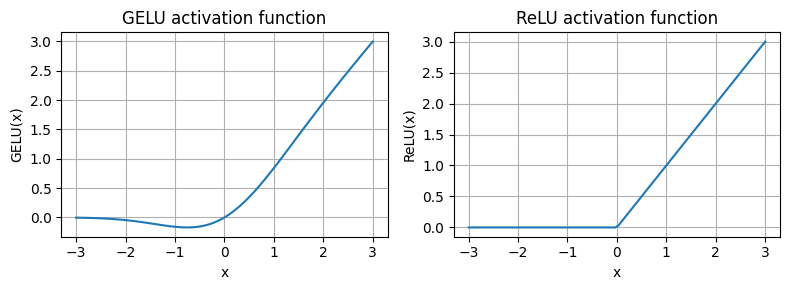

In [126]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1,2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

The smoothness of GELU can lead to better optimization properties during training, as it allows for more nuanced adjustments to the model’s parameters. In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder, especially in networks that are very deep or have complex architectures. Moreover, unlike ReLU, which outputs zero for any negative input, GELU allows for a small, non-zero output for negative values. This characteristic means that during the training process, neurons that receive negative input can still contribute to the learning process, albeit to a lesser extent than positive inputs.

In [127]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 4 is hyperparameter
        self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),)

    def forward(self, x):
        return self.layers(x)

As we can see, the FeedForward module is a small neural network consisting of two Linear layers and a GELU activation function. In the 124-million-parameter GPT model, it receives the input batches with tokens that have an embedding size of 768 each via the GPT_CONFIG_124M dictionary where GPT_CONFIG_ 124M["emb_dim"] = 768. Figure 4.9 shows how the embedding size is manipulated inside this small feed forward neural network when we pass it some inputs.

![Fig4.9a](../Images/Fig4.9a.png)

The FeedForward module plays a crucial role in enhancing the model’s ability to learn from and generalize the data. Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higherdimensional space through the first linear layer, as illustrated in figure 4.10. This expansion is followed by a nonlinear GELU activation and then a contraction back to the original dimension with the second linear transformation. Such a design allows for the exploration of a richer representation space.

![Fig4.10](../Images/Fig4.10.png)

Moreover, the uniformity in input and output dimensions simplifies the architecture by enabling the stacking of multiple layers, as we will do later, without the need to adjust dimensions between them, thus making the model more scalable.

In [128]:
#  Creates sample input with batch dimension 2
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [129]:
ffn.layers[0].weight

Parameter containing:
tensor([[-0.0223,  0.0308,  0.0022,  ..., -0.0174, -0.0227, -0.0178],
        [-0.0027, -0.0043, -0.0274,  ...,  0.0079,  0.0112,  0.0010],
        [-0.0029,  0.0175,  0.0244,  ..., -0.0164, -0.0300,  0.0045],
        ...,
        [ 0.0255,  0.0023,  0.0277,  ..., -0.0037, -0.0134, -0.0284],
        [ 0.0266,  0.0236, -0.0193,  ...,  0.0120,  0.0061, -0.0261],
        [ 0.0222,  0.0106, -0.0190,  ..., -0.0253,  0.0320, -0.0109]],
       requires_grad=True)

### 4.4 Adding shortcut connections

Let’s discuss the concept behind shortcut connections, also known as skip or residual connections. Originally, shortcut connections were proposed for deep networks in computer vision (specifically, in residual networks) to mitigate the challenge of vanishing gradients. The vanishing gradient problem refers to the issue where gradients (which guide weight updates during training) become progressively smaller as they propagate backward through the layers, making it difficult to effectively train earlier layers.

Figure 4.12 shows that a shortcut connection creates an alternative, shorter path for the gradient to flow through the network by skipping one or more layers, which is achieved by adding the output of one layer to the output of a later layer. This is why these connections are also known as skip connections. They play a crucial role in preserving the flow of gradients during the backward pass in training. In the following list, we implement the neural network in figure 4.12 to see how we can add shortcut connections in the forward method.

![Fig4.12](../Images/Fig4.12.png)

In [130]:
# Check for MPS availability and set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU.")

Using MPS device.


In [131]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        # Implements five layers
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

def print_gradients(model, x):
    # Forward pass
    output = model(x).to(device)
    target = torch.tensor([[0.]]).to(device)

    # Calculate loss based on how close rthe target
    loss = nn.MSELoss() # Cross-entropy loss
    loss = loss(output, target)

    # Backward pass to calculate the gradient
    loss.backward()

    # iterate
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")  

The code implements a deep neural network with five layers, each consisting of a Linear layer and a GELU activation function. In the forward pass, we iteratively pass the input through the layers and optionally add the shortcut connections if the self.use_ shortcut attribute is set to True.

The function (print_gradients) code specifies a loss function that computes how close the model output and a user-specified target (here, for simplicity, the value 0) are. Then, when calling loss.backward(), PyTorch computes the loss gradient for each layer in the model. We can iterate through the weight parameters via model.named_parameters(). Suppose we have a 3 × 3 weight parameter matrix for a given layer. In that case, this layer will have 3 × 3 gradient values, and we print the mean absolute gradient of these 3 × 3 gradient values to obtain a single gradient value per layer to compare the gradients between layers more easily. In short, the .backward() method is a convenient method in PyTorch that computes loss gradients, which are required during model training, without implementing the math for the gradient calculation ourselves, thereby making working with deep neural networks much more accessible.

In [132]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]]).to(device)

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
).to(device)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011160288238898
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645900726318


The output of the print_gradients function shows, the gradients become smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which is a phenomenon called the vanishing gradient problem.

In [133]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]]).to(device)

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
).to(device)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169794142246246
layers.1.0.weight has gradient mean of 0.20694108307361603
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258543014526367


The last layer (layers.4) still has a larger gradient than the other layers. However, the gradient value stabilizes as we progress toward the first layer (layers.0) and doesn’t shrink to a vanishingly small value.

In conclusion, shortcut connections are important for overcoming the limitations posed by the vanishing gradient problem in deep neural networks. Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective training by ensuring consistent gradient flow across layers when we train the GPT model in the next chapter.

### 4.5 Connecting attention and linear layers in a transformer block

Now, let’s implement the transformer block, a fundamental building block of GPT and other LLM architectures. This block, which is repeated a dozen times in the 124-million parameter GPT-2 architecture, combines several concepts we have previously covered: multi-head attention, layer normalization, dropout, feed forward layers, and GELU activations. Later, we will connect this transformer block to the remaining parts of the GPT architecture.

Figure 4.13 shows a transformer block that combines several components, including the masked multi-head attention module (see chapter 3) and the FeedForward module we previously implemented (see section 4.3). When a transformer block processes an input sequence, each element in the sequence (for example, a word or subword token) is represented by a fixed-size vector (in this case, 768 dimensions). The operations within the transformer block, including multi-head attention and feed forward layers, are designed to transform these vectors in a way that preserves their dimensionality.

![Fig4.13](../Images/Fig4.13.png)


The idea is that the self-attention mechanism in the multi-head attention block identifies and analyzes relationships between elements in the input sequence. In contrast, the feed forward network modifies the data individually at each position. This combination not only enables a more nuanced understanding and processing of the input but also enhances the model’s overall capacity for handling complex data patterns.